In [11]:
import urllib.request
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filename = "tinyshakespeare.txt"
urllib.request.urlretrieve(url, filename)

with open(filename) as f:
    raw_input = f.read()

raw_input = raw_input.lower().replace('\n', ' ')
print("data length: %s, first 100 characters: '%s...'" % (len(raw_input), raw_input[:100]))

data length: 1115394, first 100 characters: 'first citizen: before we proceed any further, hear me speak.  all: speak, speak.  first citizen: you...'


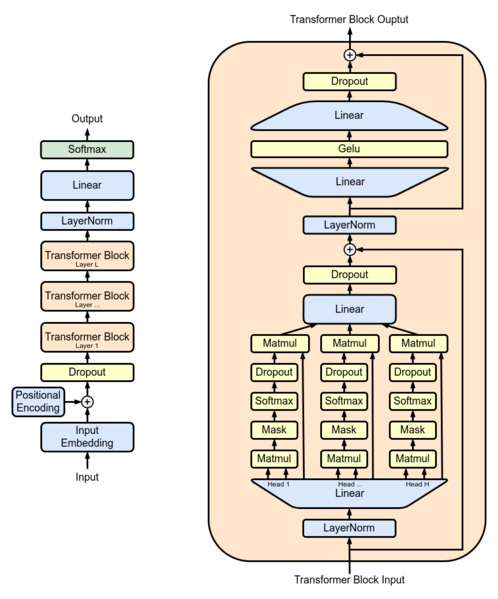

In [15]:
from IPython import display
display.Image("https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Full_GPT_architecture.png/498px-Full_GPT_architecture.png")

In [16]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib as plt
import typing # https://docs.python.org/3/library/typing.html

In [12]:
# Formal algorithms for transformers; https://arxiv.org/pdf/2207.09238.pdf
# The annotated transformer: https://nlp.seas.harvard.edu/2018/04/03/attention.html

In [ ]:
TokenId = int # type alias for token id

class Hyperparameters:
    def __init__(self):  
        self.l_max = None # max sentence length
        self.d_e = None # embedding dimension size
        self.d_mlp = None # MLP dimension
        self.d_attn = None # attention dimension
        self.epochs = None 
        self.num_heads = None # number of heads
        self.learning_rate = None

class HeadAtttention(nn.Module):
    def __init__(self, d_word, d_ctx, d_attn_embed, d_out):
        self.W_q = torch.tensor(size=[d_word, d_attn_embed])
        self.W_k = torch.tensor(size=[d_ctx, d_attn_embed])
        self.W_v = torch.tensor(size=[d_ctx, d_out])
    
    # TODO: add mask
    def forward(self, sentence, context):
        """
        sentence: [NWORDS;D_WORD]
        context: [NCWORDS;D_CTX]
        out: [NWORDS;D_OUT]
        """
        Q = sentence @ self.W_q #[NWORDS;D_ATTN_EMBED] 
        K = context @ self.W_k #[NCWORDS;D_ATTN_EMBED]
        V = context @ self.W_v #[NCWORDS;D_OUT]
        
        QK = Q @ K.T # [NWORDS;NCWORDS]
        # sum[ci] (QK_normalize[w, ci]) = 1 forall w
        QK_normalize = torch.softmax(QK, dim=1) # [NWORDS;NCWORDS]
        out = QK_normalize @ V # [NWORDS;D_OUT]
        return out 

class MultiHeadAttention(nn.Module):
    """
    sentence: [NWORDS;D_WORD]
    context: [NCWORDS;D_CTX]
    out: [NWORDS;D_OUT]
    """
    def __init__(self, d_word, d_ctx, d_attn_embed, d_out, nheads):
        assert d_out % nheads == 0
        self.heads = [HeadAtttention(d_word, d_ctx, d_attn_embed, d_out // nheads) for _ in range(nheads)]

    def forward(self, sentence, context):
        # List[NWORDS;D_OUT//NHEADS], |outs| = NHEADS
        outs = [head(sentence, context) for head in self.heads]
        outs = torch.cat(outs, dim=1) # [NWORDS;D_OUT]
        return outs 

class Parameters:
    class HeadParameters:
        def __init__(self, hp: Hyperparameters):
            self.W_q = torch.nn.init.xavier_uniform(torch.tensor(size=(hp.d_e, hp.d_attn))) 
            self.W_k = torch.tensor(size=[hp.d_e, hp.d_attn]) #
            # d_e // hp.num_heads
            assert hp.d_e % hp.num_heads == 0
            self.W_v = torch.tensor(size=[hp.d_attn, hp.d_e // hp.num_heads]) #
            self.b_q = torch.tensor(size=[hp.d_attn])  #
            self.b_k = torch.tensor(size=[hp.d_attn]) #
            self.b_v = None #
    
    class LayerParameters:
        def __init__(self, hyper_params: Hyperparameters):
            self.multi_head_parms = [Parameters.HeadParameters(hyper_params) for _ in range(hyper_params.H)]
            self.gamma_1 = None 
            self.gamma_2 = None
            self.beta_1 = None 
            self.beta_2 = None
            # can be made into a class, but is it worth it? 
            self.mlp1_W = None
            self.mlp2_W = None
            self.mlp1_b = None
            self.mlp2_b = None
            self.W_o = None # output projection from W (multi head attention)
            self.b_o = None # output bias from W (multi head attention)

    def __init__(self, hyper_params: Hyperparameters):
        self.W_e = None 
        self.W_p = None 
        self.W_u = None
        self.attention_mask = None  
        self.layer_params = [Parameters.LayerParameters(hyper_params) for _ in range(hyper_params.L)]

class Layer_Norm(nn.Module):
    """
    Algorithm 6
    """
    def __init__(self, gamma, beta):
        self.gamma = gamma
        self.beta = beta

    def forward(self, e):
        m = e.mean()
        v = e.var()
        return (((e - m) / torch.sqrt(v)) * self.gamma) + self.beta


class DTransformer(nn.Module):
    """
    Algorithm 10
    Implements a decoder only transformer.
    """
    def __init__(self, l_max, W_e, W_p, W_u, gamma_1, beta_1, 
                 gamma_2, beta_2, gamma_3, beta_3, hyperparameters: Hyperparameters, params: Parameters):
        self.W_e = W_e
        self.W_p = W_p
        self.W_u = W_u
        self.l_max = l_max
        self.X = None
        self.layer_norm_1 = Layer_Norm(gamma_1, beta_1)
        self.layer_norm_2 = Layer_Norm(gamma_2, beta_2)
        self.layer_norm_3 = Layer_Norm(gamma_3, beta_3)
        self.MHAttention = MultiHeadAttention(hyperparameters.d_word, hyperparameters.d_ctx, hyperparameters.d_attn_embed,
                                              hyperparameters.d_out, hyperparameters.num_heads)
        self.layer_parms = params.LayerParameters

    def forward(self, x):
        self.X = [self.W_e[:, x[t]] + self.W_p[:, t] for t in self.l_max]
        for l in range(self.l_max):
            for t in range(l):
                self.X[:, t] = self.layer_norm_1(self.X[:, t])
            self.X += self.MHAttention(self.X, self.X)
            for t in range(l):
                self.X[:, t] = self.layer_norm_2(X[:, t])
            
            gelu_arg = ((self.layer_parms.mlp1_W[:, l] @ self.X)
                        + self.layer_parms.mlp1_b[l]) # Confirm if 'l' means the column
            X += (self.layer_parms.mlp2_W[:, l] @ torch.gelu(gelu_arg)
                  + self.layer_parms.mlp2_b) # Confirm if 'l' means the column

        for t in range(l): X[:, t] = self.layer_norm_3(X[:, t])
        return torch.softmax(self.W_u @ self.X)


def DTraining(x, params: Parameters):
    """Algorithm 13"""
    # TODO: gather all parameters.
    # if we use `torch.nn`, then we can just do `model.parameters()`.
    optimizer = torch.optim.Adam([var1, var2], lr=0.0001, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    n_data = x.size() # Does size work ?    
    nsteps = 0 # total number of steps for error reporting.
    for i in range(Hyperparameters.epochs):
        for n in range(n_data):
            optimizer.zero_grad()
            l = x[n].size()
            # we use torch cross entropy loss + ADAM.
            p_theta = DTransformer(x[n][: l], params)
            # we want the model to assign full probability to the *next* token.
            # we penalize it for uncertainty in the next token by using cross-entropy loss.
            loss = loss_fn(p_theta, x[n][l])
            loss.backward()
            
            # Adjust learning weights
            optimizer.step()

            # Gather data and report
            running_loss += loss.item()
            
            nsteps += 1
            if nsteps % 1000 == 999:
                last_loss = running_loss / 1000 # loss per batch
                print('  batch {} loss: {}'.format(i + 1, last_loss))
            

def DInference(x, l_gen : int, temperature : float, params: Parameters):
    """Algorithm 14"""
    l = x.size() 
    for i in range(l_gen):
        P = DTransformer(x, params)
        p = P[:, l + i - 1]
        # sample from the distribution
        vocab = [] # need vocab
        tok_ix = np.random.choice(a=len(vocab), p=p)
        tok = vocab[tok_ix]
        x.append(tok_ix)
    return x[l:] # return the generated part of the sequence.